Используются данные `s_6.first10000.fastq`.

(Ершов Артем, Москва)

Используются данные `s_6.first10000.fastq`. Графы в формате `.dot`, `.pdf` и рёбра в `.fasta` находятся репозитории в `./HW5_data`.


In [1]:
from collections import defaultdict
from copy import deepcopy

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from graphviz import Digraph
from tqdm import tqdm

# 0 Реализация

In [76]:
class Edge:
    def __init__(self, n1, n2, seq, dbg, primal_id=None, coverage=None):
        assert not (primal_id is None and coverage is None), 'something went horribly wrong...'
        self.out_node = n1
        self.in_node = n2
        self.primal_id = primal_id
        self.seq = seq   # (на самом деле содержит список к-меров в порядке прохода)
        self.dbg = dbg
        self._coverage = coverage

    def __len__(self):
        return len(self.seq)

    def coverage(self):
        if self._coverage is None:
            return self.dbg.edge_coverage[self.primal_id]
        else:
            return self._coverage

    def __hash__(self):
        return hash(str(seq))

    def __repr__(self):
        return f'Edge(out={self.out_node}, in={self.in_node}, seq={self.seq})'

        
class DeBruijnGraph:
    
    def __init__(self, k=55, min_edge_length=100, min_edge_coverage=30):
        self.k = k
        self.min_edge_length = min_edge_length
        self.min_edge_coverage = min_edge_coverage
        
        self.node_counter = 0
        
        self.nodes = set()
        
        self.kmer_encode = {}  # кмер: число
        self.kmer_decode = {}  # число: кмер
        self.kmer_coverage = defaultdict(int)
        
        self.edge_encode = {}
        self.edge_decode = {}
        self.edge_counter = 0
        self.edges = set()
        self.edge_coverage = defaultdict(int)  # покрытие рёбер k+1 - мерами
        
        self.adj_list_in = defaultdict(list)
        self.adj_list_out = defaultdict(list)
        
        self.edges = defaultdict(dict)
        
        self.label = ""
    
    def filename(self):
        """Возвращает имя (последнего) файла (без расширения), по которому был построен граф"""
        return '.'.join(self.label.split('.')[:-1])
        
    def read_file(self, path, extension='fasta'):
        """Добавляет в граф вершины и рёбра по заданному файлу"""
        self.label = path
        with open(path, 'r') as f:
            for rec in tqdm(SeqIO.parse(f, extension)):
                self.read_string(rec.seq)
                self.read_string(rec.seq.reverse_complement())
        
    def read_string(self, seq):
        edge_length = self.k + 1
        for i in range(len(seq) - edge_length + 1):
            edge_seq = seq[i:i+edge_length]
            source_seq = edge_seq[:-1]
            sink_seq = edge_seq[1:]
            
            for kmer in (source_seq, sink_seq):
                if kmer not in self.kmer_encode.keys():
                    self.kmer_encode[kmer] = self.node_counter
                    self.kmer_decode[self.node_counter] = kmer
                    self.node_counter += 1
                    
            if edge_seq not in self.edge_encode.keys():
                self.edge_encode[edge_seq] = self.edge_counter
                self.edge_decode[self.edge_counter] = edge_seq
                self.edge_counter += 1
            edge_id = self.edge_encode[edge_seq]
            self.edge_coverage[edge_id] += 1
                
            source_id = self.kmer_encode[source_seq]
            sink_id = self.kmer_encode[sink_seq]
            
            self.adj_list_out[source_id].append(sink_id)
            self.adj_list_in[sink_id].append(source_id)
            
            self.kmer_coverage[sink_id] += 1
            self.kmer_coverage[source_id] += 1
            
            self.nodes.add(source_id)
            self.nodes.add(sink_id)
            
            
            edge = Edge(source_id, sink_id, [source_id, sink_id], self, edge_id)
            self.edges[source_id][sink_id] = edge
            
    def compress(self):
        # Рекурсия не завелась, поэтому бродим в цикле до тех пор, 
        # пока будет нечего больше сжимать
        flag = True
        while flag:
            for node in self.nodes:
                if len(set(self.adj_list_in[node])) == len(set(self.adj_list_out[node])) == 1:
                    # строим новое ребро
                    new_source = next(iter(self.adj_list_in[node]))
                    new_sink = next(iter(self.adj_list_out[node]))
                    old_edge1 = self.edges[new_source].pop(node)
                    old_edge2 = self.edges.pop(node)[new_sink]
                    
                    # здесь считается покрытие через среднее взвешенное от рёбер
                    n1, n2 = len(old_edge1), len(old_edge2)
                    cov1, cov2 = old_edge1.coverage(), old_edge2.coverage()
                    new_coverage = (cov1 * n1 + cov2 * n2) / (n1 + n2)
                    
                    new_edge = Edge(new_source, new_sink, old_edge1.seq + old_edge2.seq[1:], self, 
                                   coverage=new_coverage)
                    self.edges[new_source][new_sink] = new_edge
                    
                    # удаляем отовсюду срединную вершину
                    self.nodes.remove(node)
                    
                    self.adj_list_out[new_source].append(new_sink)
                    self.adj_list_out[new_source] = self.remove_node(node, self.adj_list_out[new_source]) 
                    
                    self.adj_list_in[new_sink].append(new_source)
                    self.adj_list_in[new_sink] = self.remove_node(node, self.adj_list_in[new_sink]) 
                    
                    self.adj_list_in.pop(node)
                    self.adj_list_out.pop(node)
                    
                    break
            if self.is_compressed():
                flag = False
        self.remove_lonesome_nodes()
        
    def is_compressed(self):
        """Проверяет, остались ли ещё вершины со степенями 1"""
        for node in self.nodes:
            if len(set(self.adj_list_in[node])) == len(set(self.adj_list_out[node])) == 1:
                return False
        return True
    
    def remove_loose_ends(self):
        """Удаляет короткие и малопокрытые концевые рёбра"""
        for node in list(self.nodes):
            indegree = len(set(self.adj_list_in[node]))
            outdegree = len(set(self.adj_list_out[node]))
            # если входящая или исходящая степень равна единице...
            if indegree + outdegree == 1:
            
                if indegree == 1:
                    source = self.adj_list_in[node][0]
                    edge = self.edges[source][node]
                    # length = len(edge.seq) + self.k - 1
                    # coverage = self.mean_edge_coverage(edge.seq)
                    length = len(edge)
                    coverage = edge.coverage()
                    
                    if length < self.min_edge_length or coverage < self.min_edge_coverage:
                        self.nodes.remove(node)
                        self.adj_list_in.pop(node)
                        self.adj_list_out[source] = self.remove_node(node, self.adj_list_out[source])
                        self.edges[source].pop(node)
                        
                elif outdegree == 1:
                    sink = self.adj_list_out[node][0]
                    edge = self.edges[node][sink]
                    # length = len(edge.seq) + self.k - 1
                    # coverage = self.mean_edge_coverage(edge.seq)
                    length = len(edge)
                    coverage = edge.coverage()
                    
                    if length < self.min_edge_length or coverage < self.min_edge_coverage:
                        self.nodes.remove(node)
                        self.adj_list_out.pop(node)
                        self.adj_list_in[sink] = self.remove_node(node, self.adj_list_in[sink])
                        self.edges.pop(node)
        # возможно теперь получится сильнее сжать граф...    
        self.compress()
        
    def remove_bad_edges(self):
        for source, sinks in list(self.edges.items()):
            for sink, edge in list(sinks.items()):
                coverage = edge.coverage()
                length = len(edge)
                if length < self.min_edge_length or coverage < self.min_edge_coverage:
                    self.edges[source].pop(sink)
                    self.adj_list_out[source] = self.remove_node(sink, self.adj_list_out[source])
                    self.adj_list_in[sink] = self.remove_node(source, self.adj_list_in[sink])
        self.compress()
                
    def remove_lonesome_nodes(self):
        """Удаляет вершины со степенями 0"""
        for node in list(self.nodes):
            indegree = len(self.adj_list_in[node])
            outdegree = len(self.adj_list_out[node])
            if indegree == outdegree == 0:
                self.nodes.remove(node)
                if node in self.adj_list_in.keys():
                    self.adj_list_in.pop(node)
                if node in self.adj_list_out.keys():
                    self.adj_list_out.pop(node)
                if node in self.edges.keys():
                    self.edges.pop(node)
    
    def edges_to_fasta(self, filename=None):
        if filename == None:
            filename = self.filename()
        edge_counter = 1
        seq_records = []
        for source, sinks in self.edges.items():
            for sink, edge in sinks.items():
                seq_records.append(SeqRecord(id=filename + "-" + str(edge_counter),
                                  seq=self.reconstruct_seq(edge.seq), description=''))
        SeqIO.write(seq_records, filename + '.fasta', 'fasta')
                
    def make_dot_graph(self, filename=None):
        dot = Digraph()
        for source, sinks in self.edges.items():
            if len(sinks):
                dot.node(str(source))
            for sink, edge in sinks.items():
                dot.node(str(sink))
                dot.edge(str(source), str(sink), 
                label=f'Length = {len(edge.seq) + self.k - 1};\n Coverage = {round(edge.coverage(), 2)}')
        if filename is not None:
            dot.render(filename + '.gv')
        return dot 
    
    def reconstruct_seq(self, kmer_codes):
        """
        Возвращает последовательность, восстановленную по списку 
        кодов к-меров, содержащихся в ребре
        """
        seq = self.kmer_decode[kmer_codes[0]]
        for code in kmer_codes[1:]:
            seq += self.kmer_decode[code][-1]
        return seq

    def mean_edge_coverage(self, seq):
        total = sum(self.kmer_coverage[kmer] for kmer in seq)
        return round(total / len(seq), 2)
    
    @staticmethod
    def remove_node(node_code, node_list):
        """Удаляет все вхождения в список вершины с кодом node_code"""
        return list(filter(lambda x: x != node_code, node_list))

# 1. Проверка исправленного покрытия

4108it [00:02, 1678.52it/s]


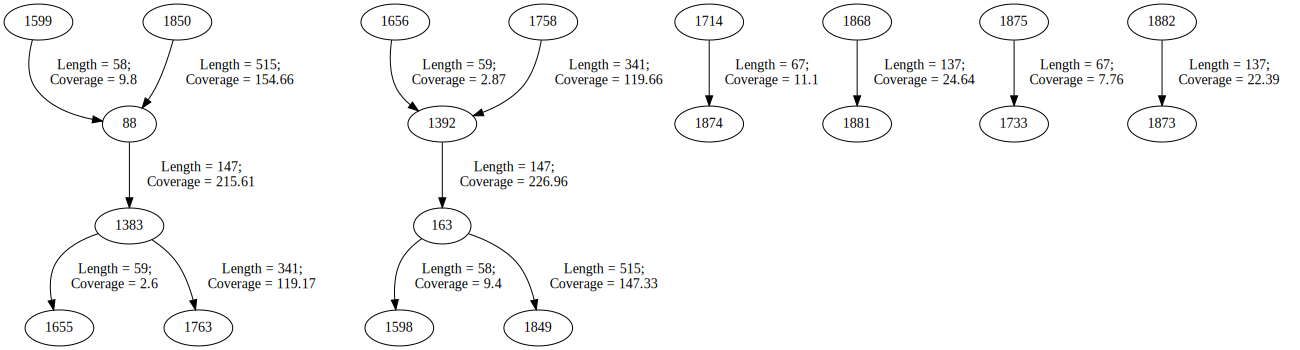

In [37]:
G = DeBruijnGraph()
G.read_file('s_6.first1000.fastq', 'fastq')
G.compress()
G.make_dot_graph()

У ошибочных рёбер покрытие теперь очень низкое. 

# 1 Сжатый граф без фильтрации рёбер

56320it [00:37, 1518.38it/s]


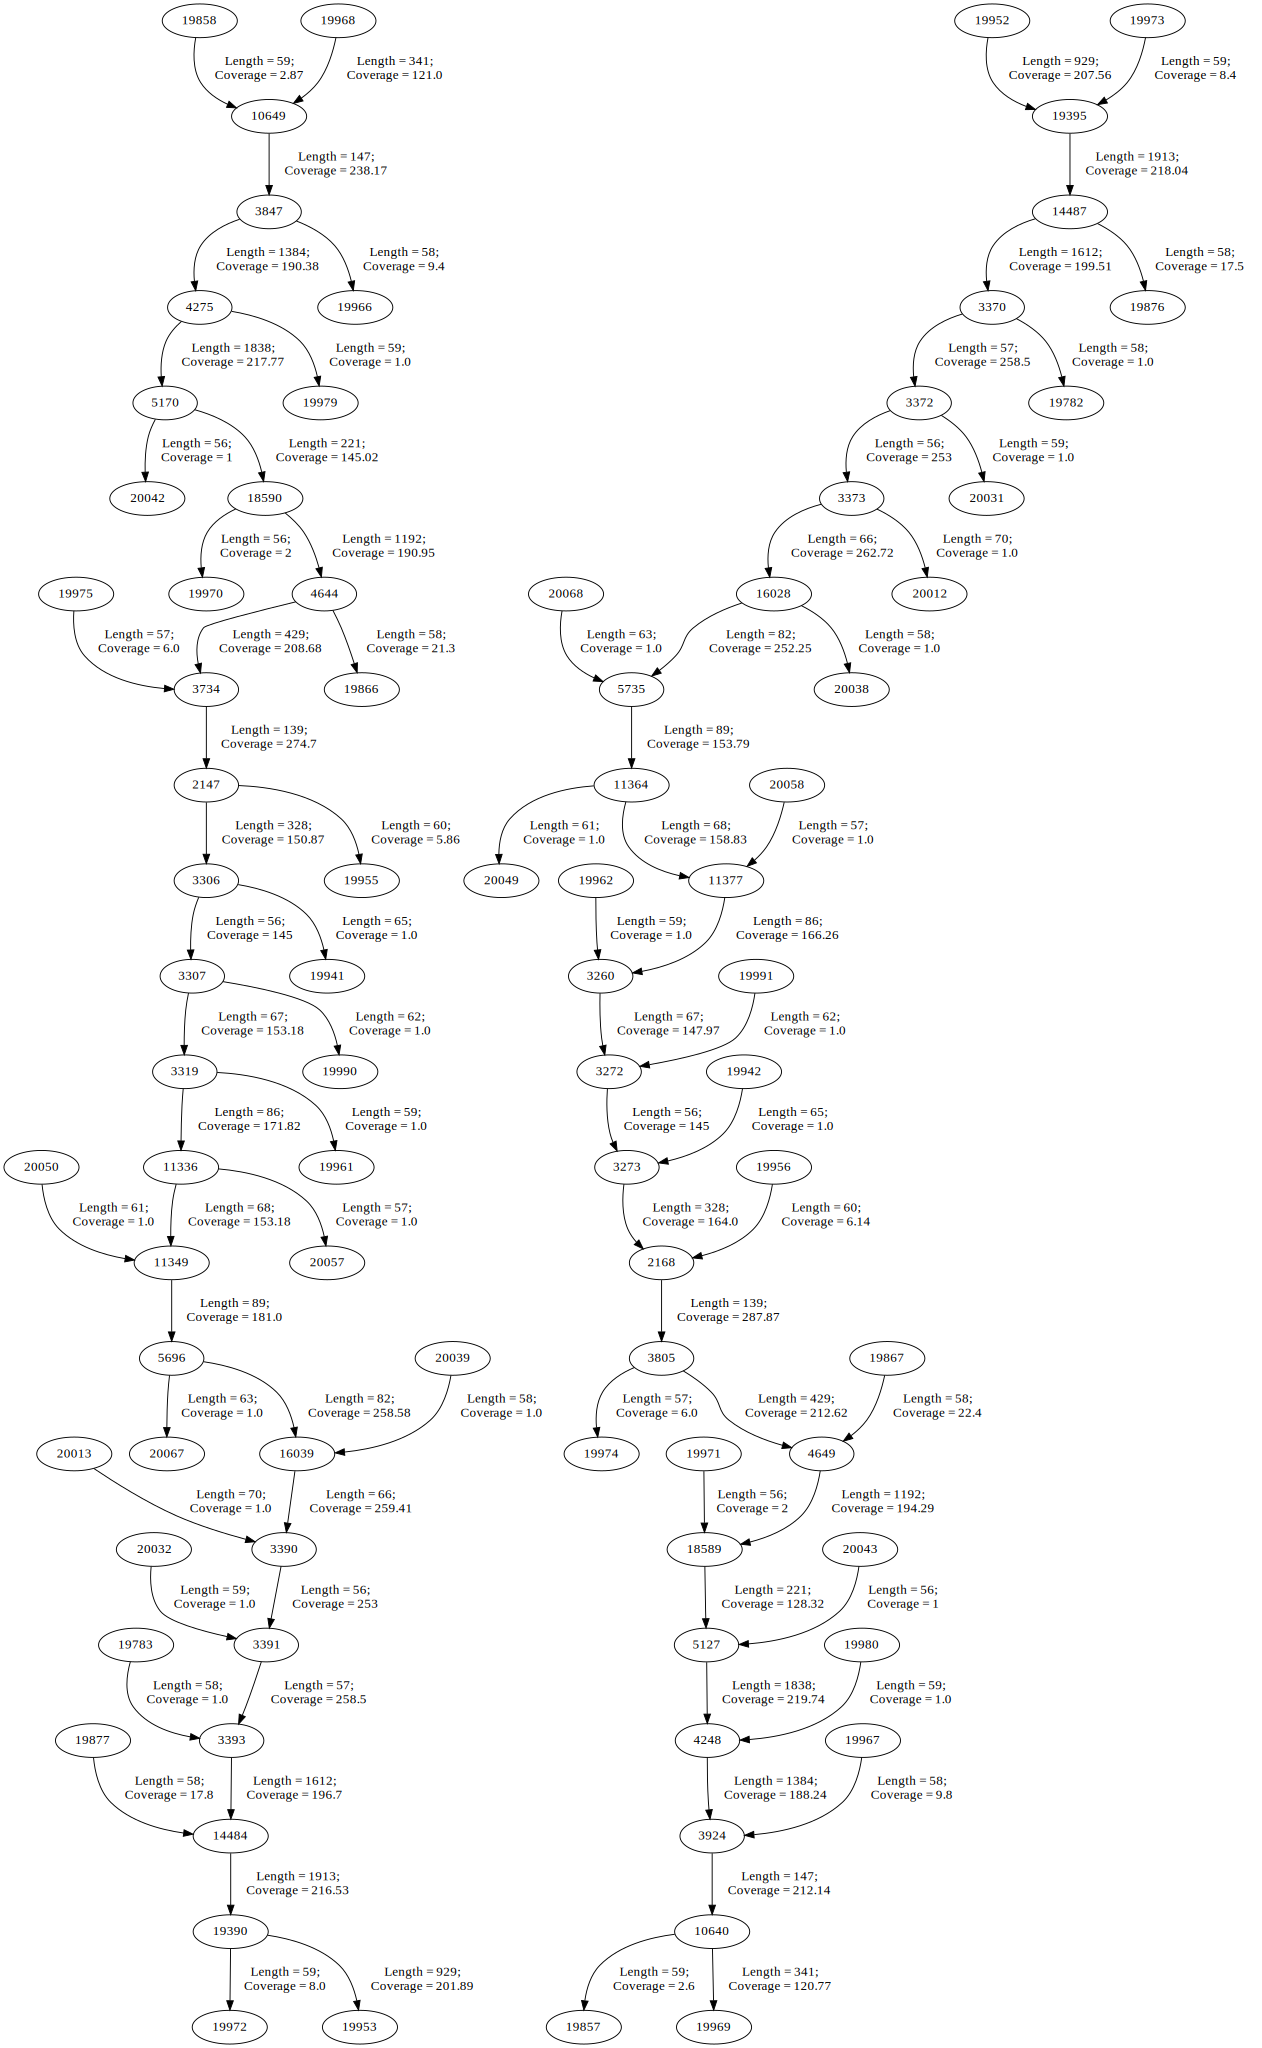

In [38]:
G = DeBruijnGraph()
G.read_file('s_6.first10000.fastq', 'fastq')
G.compress()
filename = 's6_first10000_unfiltered'
G.edges_to_fasta(filename)
G.make_dot_graph(filename)

# 2 Удаление "тупиковых" рёбер низкой длины и покрытия
Пороговые значения и для длины, и для покрытия равны 100

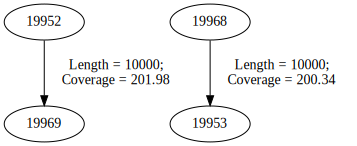

In [39]:
filename = '10k_no_loose_ends'
G_le = deepcopy(G)
G_le.remove_loose_ends()
G_le.edges_to_fasta(filename)
G_le.make_dot_graph(filename)

# 3 Удаление любых рёбер низкой длины и покрытия
Пороговые значения и для длины, и для покрытия равны 100

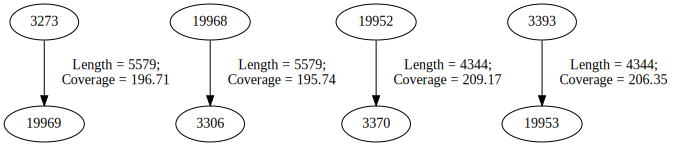

In [41]:
filename = '10k_no_bad_edges'
G_all = deepcopy(G)
G_all.min_edge_length = 65
G_all.remove_bad_edges()
G_all.edges_to_fasta(filename)
G_all.make_dot_graph(filename)

# 4 Обсуждение

Подход с применением одинаковых критериев ко всем рёбрам (т.е. удаление всех рёбер со значениями статистик ниже пороговых) опасен тем, что можно нарушить связность графа и получить на выходе более плохую сборку (в смысле, например, метрики $N50$), потому что "тупиковые" рёбра могут иметь длину и покрытие, сравнимые с рёбрами в интересующем нас самом длинном пути, что и произошло на наших данных (возможно эту проблему можно устранить более аккуратным подбором пороговых значений).

Подход с фильтрацией только тупиковых рёбер кажется более прямолинейным и удачным (судя по `first10000` в названии файла, собралось в итоге то плюс-минус то, что нужно).

# 5 Сжатый отфильтрованный граф на 100k

In [77]:
G = DeBruijnGraph(min_edge_length=65)
G.read_file('s_6.first100000.fastq', 'fastq')
G.compress()

612348it [07:29, 1363.70it/s]


In [78]:
G_le = deepcopy(G)
G_le.remove_loose_ends()
G_le.min_edge_coverage=20
G_le.min_edge_length = 0
G_le.remove_bad_edges()

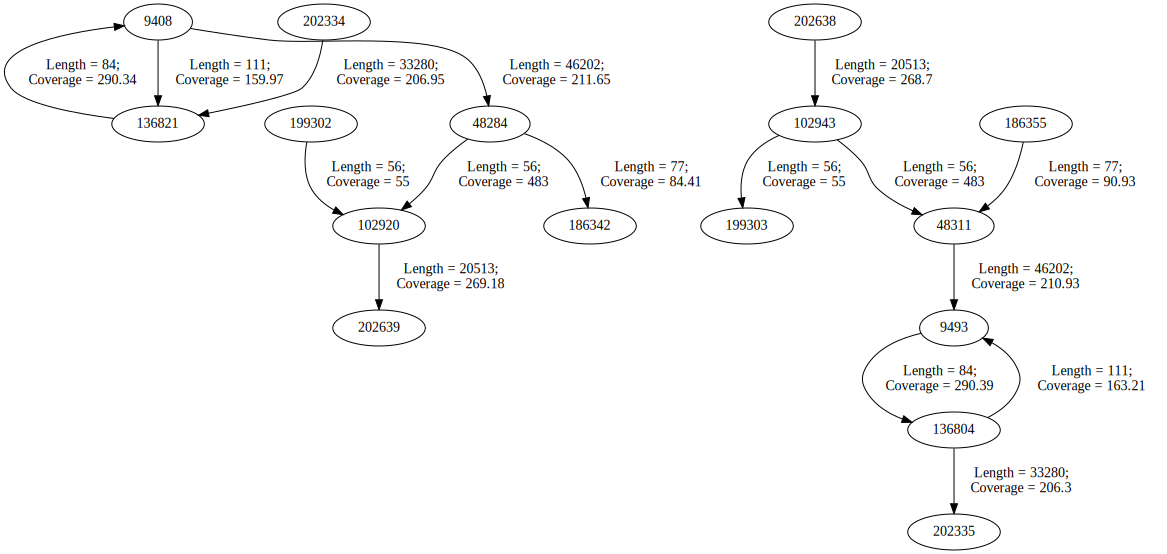

In [81]:
G_le.make_dot_graph('100k_filtered')